# Expectation-Maximisation

This is a jupyter notebook explaining illustrating the course at HTML. Check it out before diving into the code!
Note also that the proposed code is didactic and do not aim at being optimised. A good exercise when you're confortable with the EM algorithm is to code it in a matrix way yourself and remove as much as possible the for loops appearing in the following code to have better performances! Otherwise, one can still use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) package that does all of it for you.

## Data and visualisation

Let us first generate some data and visualise it.

Text(0, 0.5, '$y$')

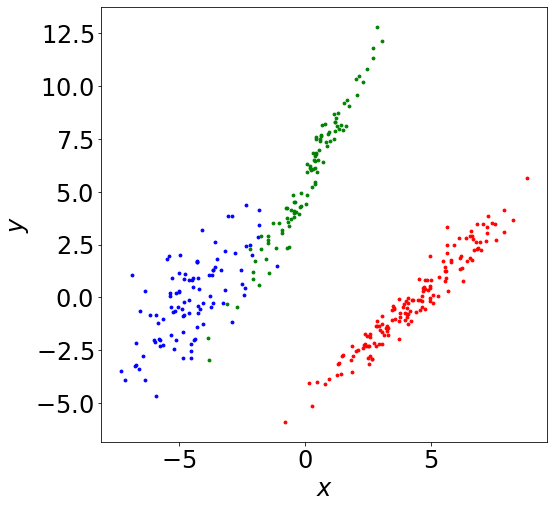

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Nice looking plots
plt.rcParams['savefig.dpi'] = 90       #Number of dpi of saved figures
plt.rcParams['font.size'] = 24
plt.rcParams['axes.formatter.limits']=(-3, 3)
plt.rcParams['axes.formatter.use_mathtext']=True

# Generate dataset
centres = np.array([[-4.5, 0], [4.5, 0], [0, 5.5]])  # Generate three centres
covariances = np.array([[[1.2, 0.7], [0.7, 1.9]], 
                        [[1.5, 1.3], [1.3, 1.8]], 
                        [[0.8, 1.1], [1.1, 2.8]]])   # Create three covariance matrices
np.random.seed(30)
d1 = np.random.randn(100, 2)@np.array(covariances[0]) + centres[0]
d2 = np.random.randn(150, 2)@np.array(covariances[1]) + centres[1]
d3 = np.random.randn(100, 2)@np.array(covariances[2]) + centres[2]

data = np.vstack((d1, d2, d3))  # Concatenate the data

fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(d1.T[0], d1.T[1], s=8, color='b')
plt.scatter(d2.T[0], d2.T[1], s=8, color='r')
plt.scatter(d3.T[0], d3.T[1], s=8, color='g')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

Our dataset is hence made of three Gaussian components that we create by hand. Now imagine you are given the dataset without this knowledge (the colors) and you have to cluster it with the Gaussian Mixture Model.

## Coding Expectation-Maximisation

We need to create the two functions corresponding the both Expectation (E) and Maximisation (M) steps.

Let's first define a function computing the Gaussian probability of a set of datapoints given parameters $\mu$, the centre and $\Sigma$, the covariance.

In [104]:
def gaussian_prob(x, mu, sig):
    '''
    Computes the probability of a datapoint given parameters of a D-dimensional Gaussian distribution.
    
    x: scalar
        Datapoint
    mu: scalar
        Centre of Gaussian
    sig: (D,D) numpy array
        Covariance matrix
    '''
    D = len(x)
    det = np.linalg.det(sig)
    inv_sig = np.linalg.inv(sig)
    
    mahal_dist = (x-mu).T @ inv_sig @ (x-mu)
    
    prob = 1/np.sqrt( (2*np.pi)**D * det ) * np.exp(-1/2*mahal_dist)
    
    return prob

The E-step consists in computing the probability of the hidden (or latent variables)

In [108]:
def E_step(X, pi, mu, sig):
    '''
    Computes the E-step of the EM algorithm. As such, it estimates the responsibilities, 
    i.e. the probabilities of each datapoint being generated by each component of the model.
    
    X: (N,D) numpy array
        Dataset
    pi: (K,) numpy array
        Amplitudes of Gaussian components
    mu: (K,D) numpy array
        Centre of Gaussian components
    sig: (K,D,D) numpy array
        Covariance matrices of Gaussian components
    
    return:
    resp: (K,) numpy array
        Responsibilities of the E-step 
    '''
    
    N,D = X.shape # Number of datapoints
    K = len(pi)   # Number of components in the Gaussian mixture model
    
    resp = np.zeros((N,K)) # The responsibility is a matrix NxK with all association of datapoints to clusters
    
    for i in range(N):
        for k in range(K):
            prob = gaussian_prob(X[i,:], mu[k], sig[k])
            
            resp[i,k] = pi[k] * prob    # This is the numerator of the E-step
            
        normalisation = np.sum(resp[i,:])  # Denominator of the E-step
        resp[i,:] = resp[i,:] / normalisation  # Real value of the responsibility   
    
    return resp

#K = 3
#mu = centres
#sig = covariances
#pi = np.ones(K)/K
#E_step(X, pi, mu, sig)